In [115]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import IsolationForest, GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD

### 1) Perform some EDA

In [116]:
df = pd.read_csv("sample.csv")
df = df.drop(columns="Unnamed: 0")

In [117]:
df.shape

(999, 12)

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Description     999 non-null    object 
 1   Author          999 non-null    object 
 2   Title           999 non-null    object 
 3   Rating          999 non-null    float64
 4   Pages           999 non-null    float64
 5   Num of Ratings  999 non-null    float64
 6   Num of Review   999 non-null    float64
 7   Genre           999 non-null    object 
 8   Publish Date    999 non-null    object 
 9   Language        993 non-null    object 
 10  Award           999 non-null    int64  
 11  ISBN            758 non-null    float64
dtypes: float64(5), int64(1), object(6)
memory usage: 93.8+ KB


In [119]:
df.describe()

,Rating,Pages,Num of Ratings,Num of Review,Award,ISBN
count,999.000000,999.000000,9.990000e+02,999.000000,999.000000,7.580000e+02
mean,4.089930,422.687688,5.310587e+05,21478.831832,0.645646,9.769374e+12
std,0.229798,283.487246,8.299394e+05,26653.611431,0.478557,3.105744e+11
min,3.400000,26.000000,1.150000e+02,9.000000,0.000000,1.230005e+12
25%,3.950000,271.500000,1.456410e+05,5864.000000,0.000000,9.780312e+12
50%,4.080000,368.000000,2.704770e+05,11622.000000,1.000000,9.780450e+12
75%,4.250000,494.000000,5.712565e+05,25417.000000,1.000000,9.780767e+12
max,4.880000,4100.000000,9.117183e+06,190980.000000,1.000000,9.789778e+12


In [120]:
df.isnull().sum()

Description         0
Author              0
Title               0
Rating              0
Pages               0
Num of Ratings      0
Num of Review       0
Genre               0
Publish Date        0
Language            6
Award               0
ISBN              241
dtype: int64

In [121]:
# check percentage of nulls
(df.isnull().sum() / df.shape[0]) * 100

Description        0.000000
Author             0.000000
Title              0.000000
Rating             0.000000
Pages              0.000000
Num of Ratings     0.000000
Num of Review      0.000000
Genre              0.000000
Publish Date       0.000000
Language           0.600601
Award              0.000000
ISBN              24.124124
dtype: float64

In [122]:
df['ISBN'] = df['ISBN'].astype(str)

In [123]:
# Num of Ratings and Num of Review are highly correlated
df.corr()

C:\Users\tnaga\AppData\Local\Temp\ipykernel_30344\4196195996.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,Rating,Pages,Num of Ratings,Num of Review,Award
Rating,1.000000,0.296325,0.109423,0.165925,0.096538
Pages,0.296325,1.000000,-0.051193,-0.041228,0.050205
Num of Ratings,0.109423,-0.051193,1.000000,0.759498,0.179092
Num of Review,0.165925,-0.041228,0.759498,1.000000,0.281673
Award,0.096538,0.050205,0.179092,0.281673,1.000000


array([[<AxesSubplot: xlabel='Rating', ylabel='Rating'>,
        <AxesSubplot: xlabel='Pages', ylabel='Rating'>,
        <AxesSubplot: xlabel='Num of Ratings', ylabel='Rating'>,
        <AxesSubplot: xlabel='Num of Review', ylabel='Rating'>,
        <AxesSubplot: xlabel='Award', ylabel='Rating'>],
       [<AxesSubplot: xlabel='Rating', ylabel='Pages'>,
        <AxesSubplot: xlabel='Pages', ylabel='Pages'>,
        <AxesSubplot: xlabel='Num of Ratings', ylabel='Pages'>,
        <AxesSubplot: xlabel='Num of Review', ylabel='Pages'>,
        <AxesSubplot: xlabel='Award', ylabel='Pages'>],
       [<AxesSubplot: xlabel='Rating', ylabel='Num of Ratings'>,
        <AxesSubplot: xlabel='Pages', ylabel='Num of Ratings'>,
        <AxesSubplot: xlabel='Num of Ratings', ylabel='Num of Ratings'>,
        <AxesSubplot: xlabel='Num of Review', ylabel='Num of Ratings'>,
        <AxesSubplot: xlabel='Award', ylabel='Num of Ratings'>],
       [<AxesSubplot: xlabel='Rating', ylabel='Num of Review'>,
    

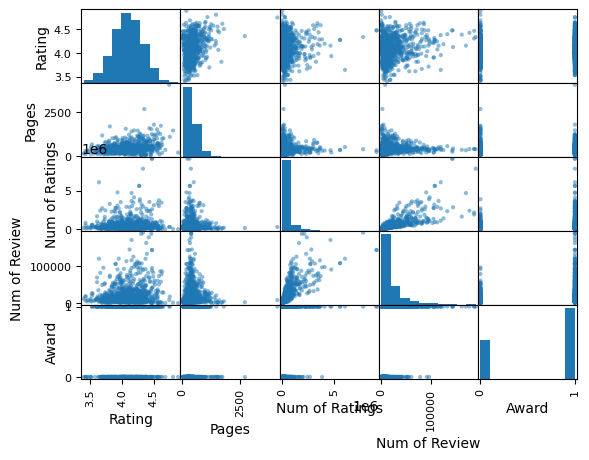

In [124]:
scatter_matrix(df)

### 2a) Data Transformation

In [125]:
# Get Dates
df_date = df['Publish Date'].str.replace("Published ","").str.split(" ", expand=True)
df_date.columns = ["Month", "Day", "Year"]
df_date["Day"] = df_date["Day"].str.replace(",", "")
df_date["Day"] = "0" + df_date["Day"]
df_date["Day"] = df_date["Day"].str[-2:]
df["Date"] = df_date["Month"] + "-" + df_date["Day"] + "-" + df_date["Year"]
df["Date"] = pd.to_datetime(df["Date"], errors='coerce', format="%B-%d-%Y")

In [126]:
# Get Author Counts Frequency Encoded
df_author_counts = df["Author"].value_counts()
df['Author'] = df['Author'].map(df_author_counts)

In [127]:
# Get Genre Counts Frequency Encoded
df_genre_counts = df["Genre"].value_counts()
df['Genre'] = df['Genre'].map(df_genre_counts)

In [128]:
df['English'] = [1 if e  == "English" else 0 for e in df["Language"]]

In [143]:
from sklearn.base import TransformerMixin

class Transform(TransformerMixin):
    def __init__(self, **kwargs):
        self.X = kwargs

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X 

    def get_feature_names_out(self, X):
        return X

In [144]:
# create pipeline to do imputation using median
# one hot encoding of categorial variables
# and power transformation
num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])
one_cat_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("one_hot", OneHotEncoder(drop='first')),
])
pow_num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("log", PowerTransformer()),
    ("standardize", StandardScaler()),
])
none_pipeline = Pipeline([("nothing", Transform())])

In [145]:
df = df.drop(columns = ["Language", "Num of Review", "Title", "Publish Date", "ISBN"])

KeyError: "['Language', 'Num of Review', 'Title', 'Publish Date', 'ISBN'] not found in axis"

In [146]:
df.columns

Index(['Description', 'Author', 'Rating', 'Pages', 'Num of Ratings', 'Genre',
       'Award', 'Date', 'English'],
      dtype='object')

In [147]:
num_attrs = ['Rating']
one_cat_attrs = ['Award', 'English']
pow_num_attrs = ['Pages', 'Num of Ratings']
none_attrs = ['Description', 'Date', 'Genre', 'Author']

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attrs),
    ("one_cat", one_cat_pipeline, one_cat_attrs),
    ("pow_num", pow_num_pipeline, pow_num_attrs),
    ("none", none_pipeline, none_attrs)
], sparse_threshold=0)

In [148]:
# run pipeline on training and testing data
df_prepared = preprocessing.fit_transform(df)

In [149]:
df_prep = pd.DataFrame(
    df_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=df.index)

In [152]:
df_prep.head()

,num__Rating,one_cat__Award_1,one_cat__English_1,pow_num__Pages,pow_num__Num of Ratings,none__Description,none__Date,none__Genre,none__Author
0,1.045226,1.0,1.0,0.024911,3.432074,"Could you survive on your own in the wild, wit...",2008-09-14,332,4
1,1.785378,1.0,1.0,1.67778,2.318345,Harry Potter is about to start his fifth year ...,2003-06-21,104,10
2,0.827534,0.0,1.0,-0.458823,2.574627,Alternate cover edition of ISBN 9780679783268S...,1813-01-28,332,7
3,0.783996,1.0,1.0,-0.155171,3.016141,The unforgettable novel of a childhood in a sl...,1960-01-01,332,2
4,1.306456,1.0,1.0,0.711743,1.996279,Librarian's note: An alternate cover edition c...,2006-03-01,332,2


In [153]:
df_prep.columns = ["Rating", "Award", "English", "Pages", "Num_Ratings", "Description", "Date", "Genre", "Author"]

### 2b) Data Cleaning: Create Document Representation of all common adjectives and nouns words based on descriptions

In [156]:
import nltk
from nltk import word_tokenize
from nltk import pos_tag, sent_tokenize, wordpunct_tokenize
from nltk.corpus import wordnet, words
import string
from nltk.stem import WordNetLemmatizer
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\tnaga\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [157]:
punctuation = string.punctuation
stopwords = nltk.corpus.stopwords.words('english')
english_words = words.words()
cleaned_words = []

for msg in df_prep['Description']:
    msg = str(msg).lower()

    # tokenize to words in msg
    msg_tok = word_tokenize(msg)

    # tag words as parts of speech
    msg_pos = pos_tag(msg_tok)

    # get adjectives, common nouns and adjectives
    parts_of_speech = ["JJ", "JJR", "JJS", "NN", "NNS"]
    msg_wrds = []

    for tok_pos in msg_pos:
        if tok_pos[1] in parts_of_speech:
            msg_wrds.append(tok_pos[0])

    # remove punctuation
    msg_wrds_p = []
    for tok_adj in msg_wrds:
        if tok_adj not in punctuation:
            msg_wrds_p.append(tok_adj)

    # remove stopwords
    msg_wrds_s = []
    for tok_adj in msg_wrds_p:
        if tok_adj not in stopwords:
            msg_wrds_s.append(tok_adj)
    
    # remove non-english words
    msg_wrds_e = []
    for tok_adj in msg_wrds_s:
        if tok_adj in english_words:
            msg_wrds_e.append(tok_adj)

    # lemmatize message
    lemmatize = WordNetLemmatizer()
    msg_adj_lemma = []
    for tok_adj in msg_wrds_e:
        msg_adj_lemma.append(lemmatize.lemmatize(tok_adj))

    str_msg = " ".join(msg_adj_lemma)
    cleaned_words.append(str_msg)

df['Clean_Description'] = cleaned_words

In [158]:
vect_model = CountVectorizer(max_df=0.95, min_df=0.05, stop_words='english', strip_accents="ascii")
corpus = vect_model.fit_transform(df['Clean_Description'])
corpus = corpus.todense()
df_desc = pd.DataFrame(corpus, columns = vect_model.get_feature_names_out().tolist())

In [159]:
# update n depending on number of categories
n = 10
lsa = TruncatedSVD(n_components=n, n_iter=100, random_state=5)
U = lsa.fit_transform(df_desc)
df_lsa = pd.DataFrame(U, columns = [f"Description_Topic_{i+1}" for i in range(n)])

In [160]:
df_prep = df_prep.drop(columns="Description")

In [161]:
df_final = pd.concat([df_prep, df_lsa], axis=1)

In [162]:
df_final.head()

,Rating,Award,English,Pages,Num_Ratings,Date,Genre,Author,Description_Topic_1,Description_Topic_2,Description_Topic_3,Description_Topic_4,Description_Topic_5,Description_Topic_6,Description_Topic_7,Description_Topic_8,Description_Topic_9,Description_Topic_10
0,1.045226,1.0,1.0,0.024911,3.432074,2008-09-14,332,4,1.162929,-0.075667,0.833113,0.017041,0.303624,-0.487934,0.361821,-0.380181,0.307482,0.054768
1,1.785378,1.0,1.0,1.67778,2.318345,2003-06-21,104,10,1.282889,-0.114047,-0.294877,0.712938,0.388994,-0.391327,-0.574517,-0.281972,-0.025338,-0.408825
2,0.827534,0.0,1.0,-0.458823,2.574627,1813-01-28,332,7,0.487526,-0.057352,-0.486406,0.009328,-0.008529,0.904428,0.490329,-0.123184,0.416097,-0.248895
3,0.783996,1.0,1.0,-0.155171,3.016141,1960-01-01,332,2,1.952991,-0.197228,0.775006,-1.654599,-0.477610,0.306033,1.445963,0.421280,-0.645078,-0.594252
4,1.306456,1.0,1.0,0.711743,1.996279,2006-03-01,332,2,2.243955,-0.276988,-0.271203,0.442446,0.213653,0.040331,0.680119,-0.711775,0.353254,0.282848
